# Estimated noise in long versus short runs

- see formula 26 and 33

- normal: 2021, 6, 1 to 2021, 8, 15
- short: 2021, 6, 4 to 2021, 7, 18
- long: 2021, 5, 1 to 2021, 8, 15

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Germany', 'Austria',
       'France', 'Slovakia', 'Belgium', 'Italy', 'Portugal',
       'Netherlands']
traces, models, dls = {}, {}, {}

for length in ["long","normal","short"]:
    models[length] = []
    traces[length] = []
    dls[length] = []
    for country in tqdm(countries):
        model = None
        if length == "long":
            source = "/data.nst/share/soccer_project/covid_uefa_traces15/"
        else:
            source = "/data.nst/share/soccer_project/covid_uefa_traces14/"

        fstr=lambda tune, draws, max_treedepth: ( source+
            f"run"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data=0"+
            f"-prior_delay=-1"+
            f"-median_width_delay=1.0"+
            f"-interval_cps=10.0"+
            f"-f_fem=0.33"+
            f"-len={length}"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
        if os.path.exists(fstr(4000, 8000, 12)):
            try:
                model, trace = load(fstr(4000, 8000, 12))
                print(f"Use 8000 sample runs for {country}")
            except:
                pass
        if model is None and os.path.exists(fstr(2000, 4000, 12)):
            try:
                model, trace = load(fstr(2000, 4000, 12))
                print(f"Use 4000 sample runs for {country}")
            except:
                pass
        if model is None and os.path.exists(fstr(1000, 1500, 12)):
            try: 
                model, trace = load(fstr(1000, 1500, 12))
                print(f"Use 1500 sample runs for {country}")
            except:
                pass
        if model is None and os.path.exists(fstr(1000, 2000, 12)):
            try: 
                model, trace = load(fstr(1000, 2000, 12))
                print(f"Use 2000 sample runs for {country}")
            except:
                pass
        if model is None and os.path.exists(fstr(500, 1000, 12)):
            try: 
                model, trace = load(fstr(500, 1000, 12))
                print(f"Use 1000 sample runs for {country}")
            except:
                pass
        if model is None: 
            print(fstr(900, 800, 99), " not found")
            continue

        # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
        mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
        trace.posterior = trace.posterior.sel(chain=~mask)

        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
        models[length].append(model)
        traces[length].append(trace)
        dls[length].append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 2000 sample runs for England
Use 2000 sample runs for Czechia
Use 2000 sample runs for Scotland
Use 2000 sample runs for Spain
Use 2000 sample runs for Germany
Use 2000 sample runs for Austria
Use 2000 sample runs for France
Use 2000 sample runs for Slovakia
Use 2000 sample runs for Belgium
Use 2000 sample runs for Italy
Use 2000 sample runs for Portugal
Use 2000 sample runs for Netherlands


  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 8000 sample runs for Czechia
Use 8000 sample runs for Scotland
Use 8000 sample runs for Spain
Use 4000 sample runs for Germany
Use 8000 sample runs for Austria
Use 4000 sample runs for France
Use 8000 sample runs for Slovakia
Use 8000 sample runs for Belgium
Use 8000 sample runs for Italy
Use 8000 sample runs for Portugal
Use 8000 sample runs for Netherlands


  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for France
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Belgium
Use 4000 sample runs for Italy
Use 4000 sample runs for Portugal
Use 4000 sample runs for Netherlands


WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


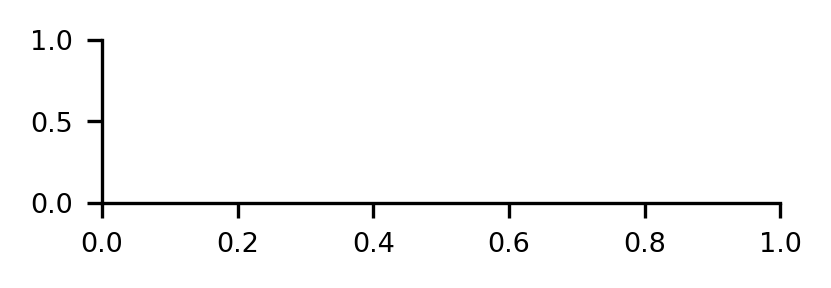

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


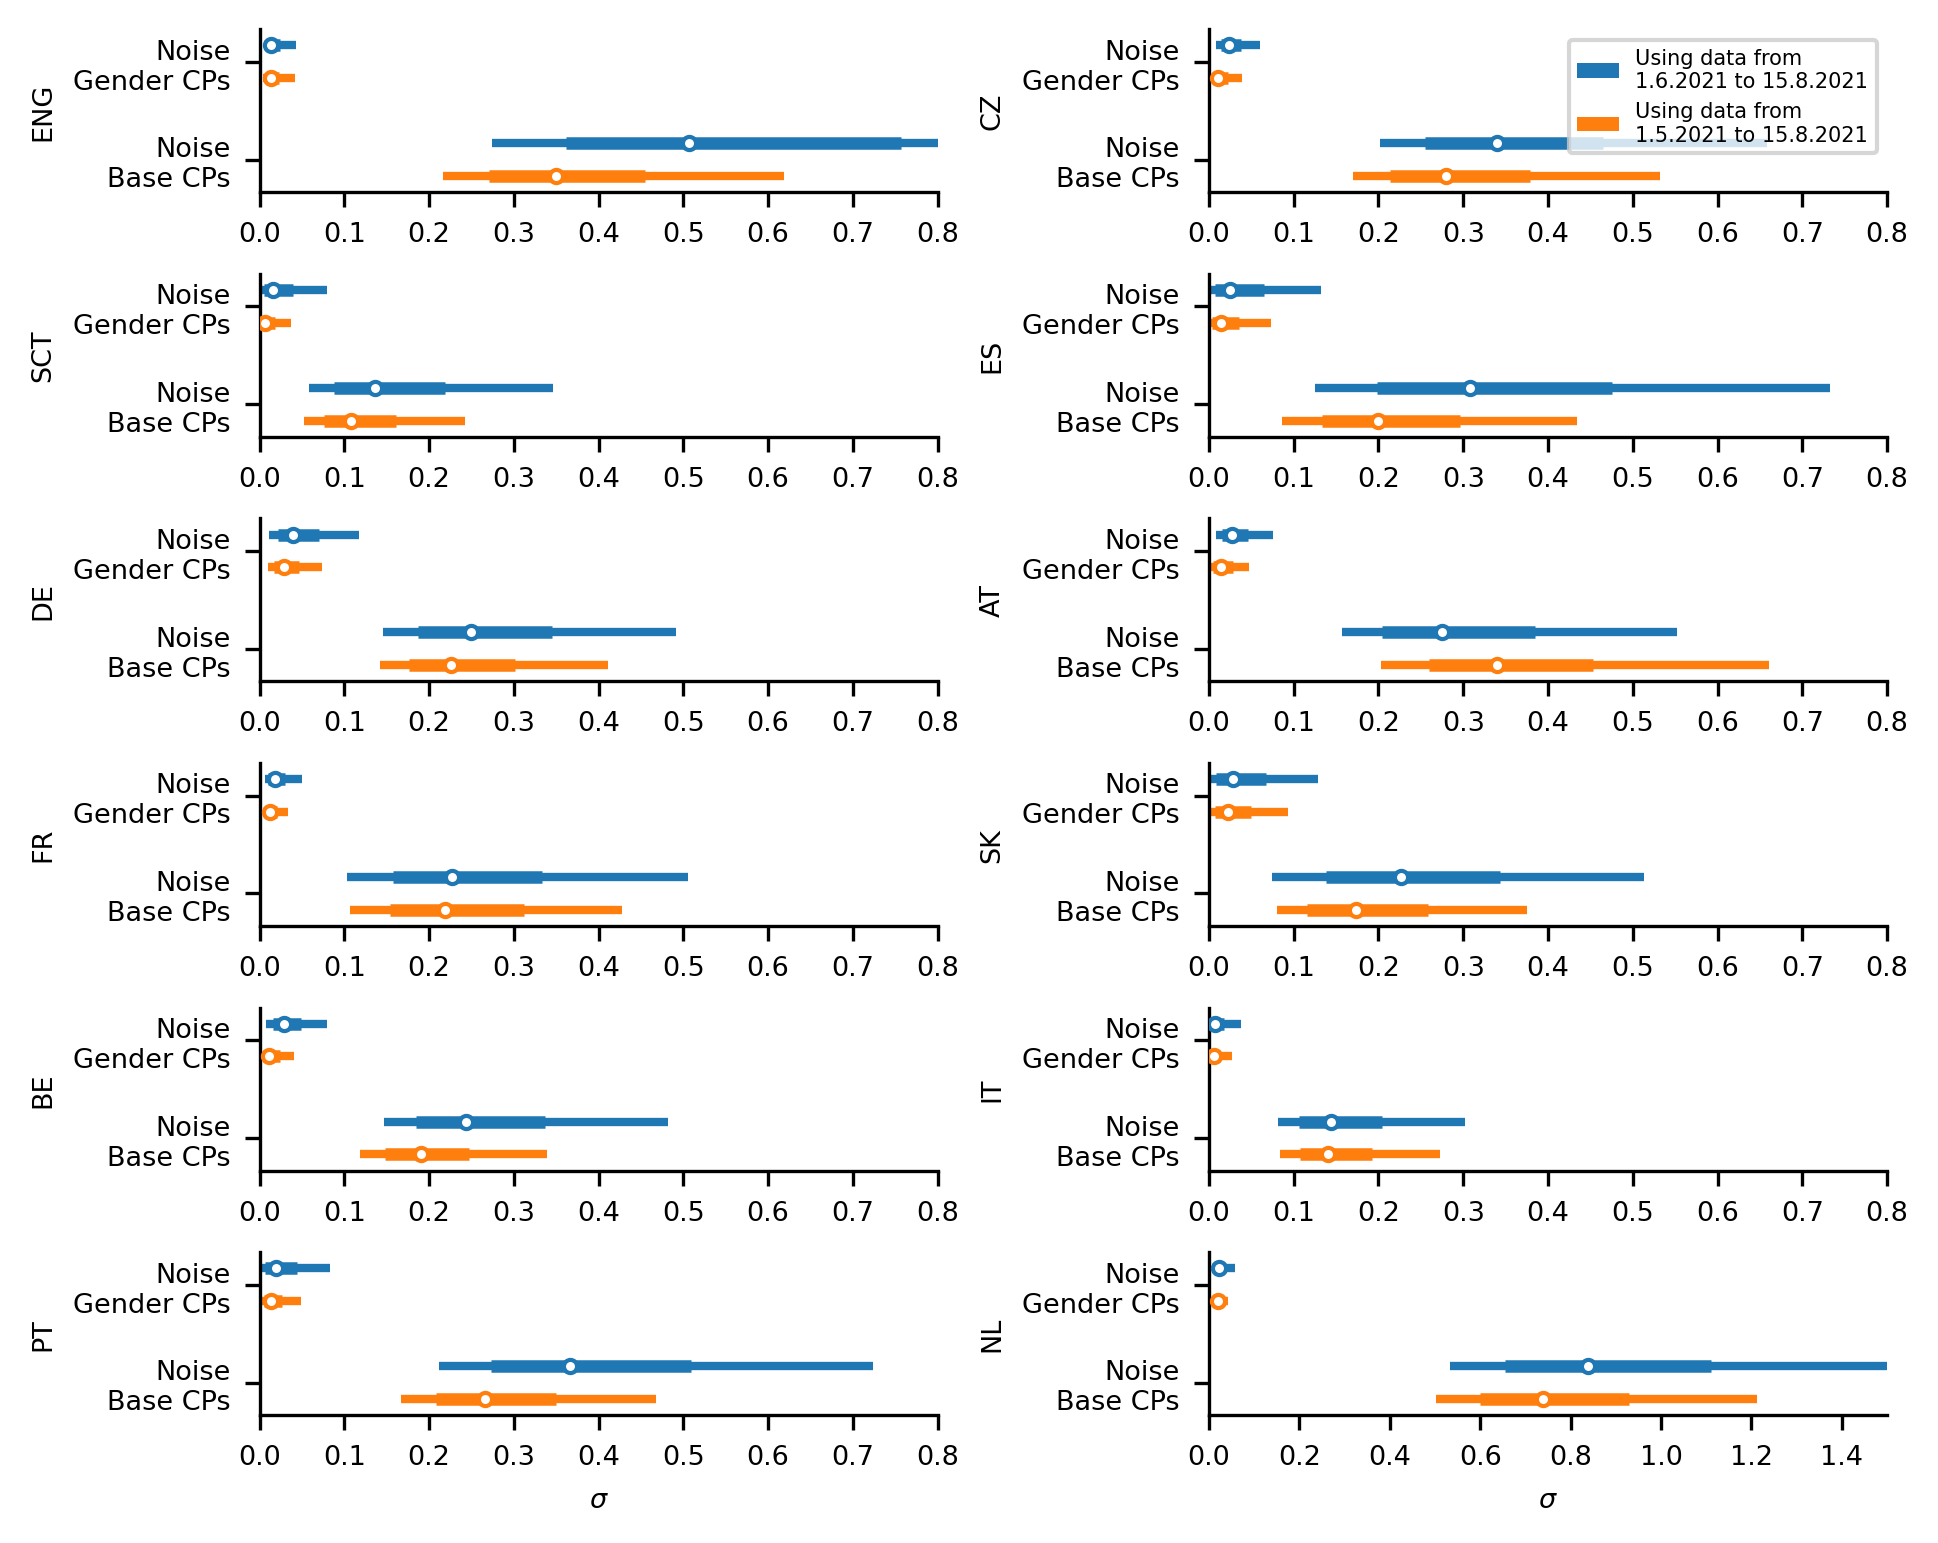

In [5]:
from covid19_soccer.plot.other import HandlerPatchImage,PatchImage,MulticolorPatchHandler,MulticolorPatch
def plot_bar(samples, color, ax, y=0):
    """ Simple bar plots showing 68 and 95% CI
    
    Parameters
    ----------
    samples: np.array
        1d array containing all samples
    color: string
        Main color of barplot
        Shading for ci is done automatically
    """
    # Compute CI
    bounds = np.percentile(samples,[50,16,84,2.5,97.5,])
    
    
    # Plot data with error

    lines_68 = ax.hlines(
            y=y,
            xmin=bounds[1],
            xmax=bounds[2],
            lw=3,
            color=color,
    )
    
    lines_95 = ax.hlines(
            y=y,
            xmin=bounds[3],
            xmax=bounds[4],
            lw=2,
            color=color,
    )
    
    ax.scatter(
        x=bounds[0],
        y=y,
        marker="o",
        s=10,
        c="white",
        zorder=10,
        edgecolor=color,
    )

    return ax

def legend(ax,loc="center"):
    # Legend
    labels = []
    lines = []

    labels.append("Using data from\n1.6.2021 to 15.8.2021") 
    lines.append(MulticolorPatch(colors=["tab:blue"]))
    
    labels.append("Using data from\n1.5.2021 to 15.8.2021")
    lines.append(MulticolorPatch(colors=["tab:orange"]))
    
    ax.legend(
        lines,
        labels,
        loc=loc,
        handler_map={MulticolorPatch:MulticolorPatchHandler()},
    )


fig, axes = plt.subplots(int(len(countries)/2),2, figsize=(7,len(countries)/2),gridspec_kw={"hspace":0.5,"wspace":0.4})
for c, country in enumerate(countries):
    r = 0
    if c >= 6:
        r = 1
    for l, length in enumerate(["long","normal"]):
        model = models[length][c]
        trace = traces[length][c]
        dl = dls[length][c]
        
        color = "tab:blue" if length == "normal" else "tab:orange"
        
        ax = axes[c%6,r]
        
        sigma_lambda_cp = get_from_trace("sigma_lambda_cp",trace)
        plot_bar(sigma_lambda_cp,color,ax,y=l)
        
        sigma_lambda_cp_noise = get_from_trace("sigma_lambda_cp_noise",trace)
        plot_bar(sigma_lambda_cp_noise,color,ax,y=l+3)


    

for ax,dl in zip(axes.flatten(),dls["long"]):
    ax.set_xlim(0,0.8)
    ax.set_ylim(-0.5,4.5)
    ax.set_yticks([0.5,3.5])
    ax.set_yticklabels(["Noise\nBase CPs","Noise\nGender CPs"])
    ax.set_ylabel(dl.countries_iso2[0].replace("GB-",""))
    if dl.countries[0] == "Netherlands":
        ax.set_xlim(0,1.5)
for ax in axes[-1]:
    ax.set_xlabel("$\sigma$")
        
legend(axes[0,1],loc=1)

plt.show()
fig.savefig(f"../../figures/SI/changepoints_sigma.pdf", **save_kwargs)
fig.savefig(f"../../figures/SI/changepoints_sigma.png", **save_kwargs)
plt.close(fig=fig)

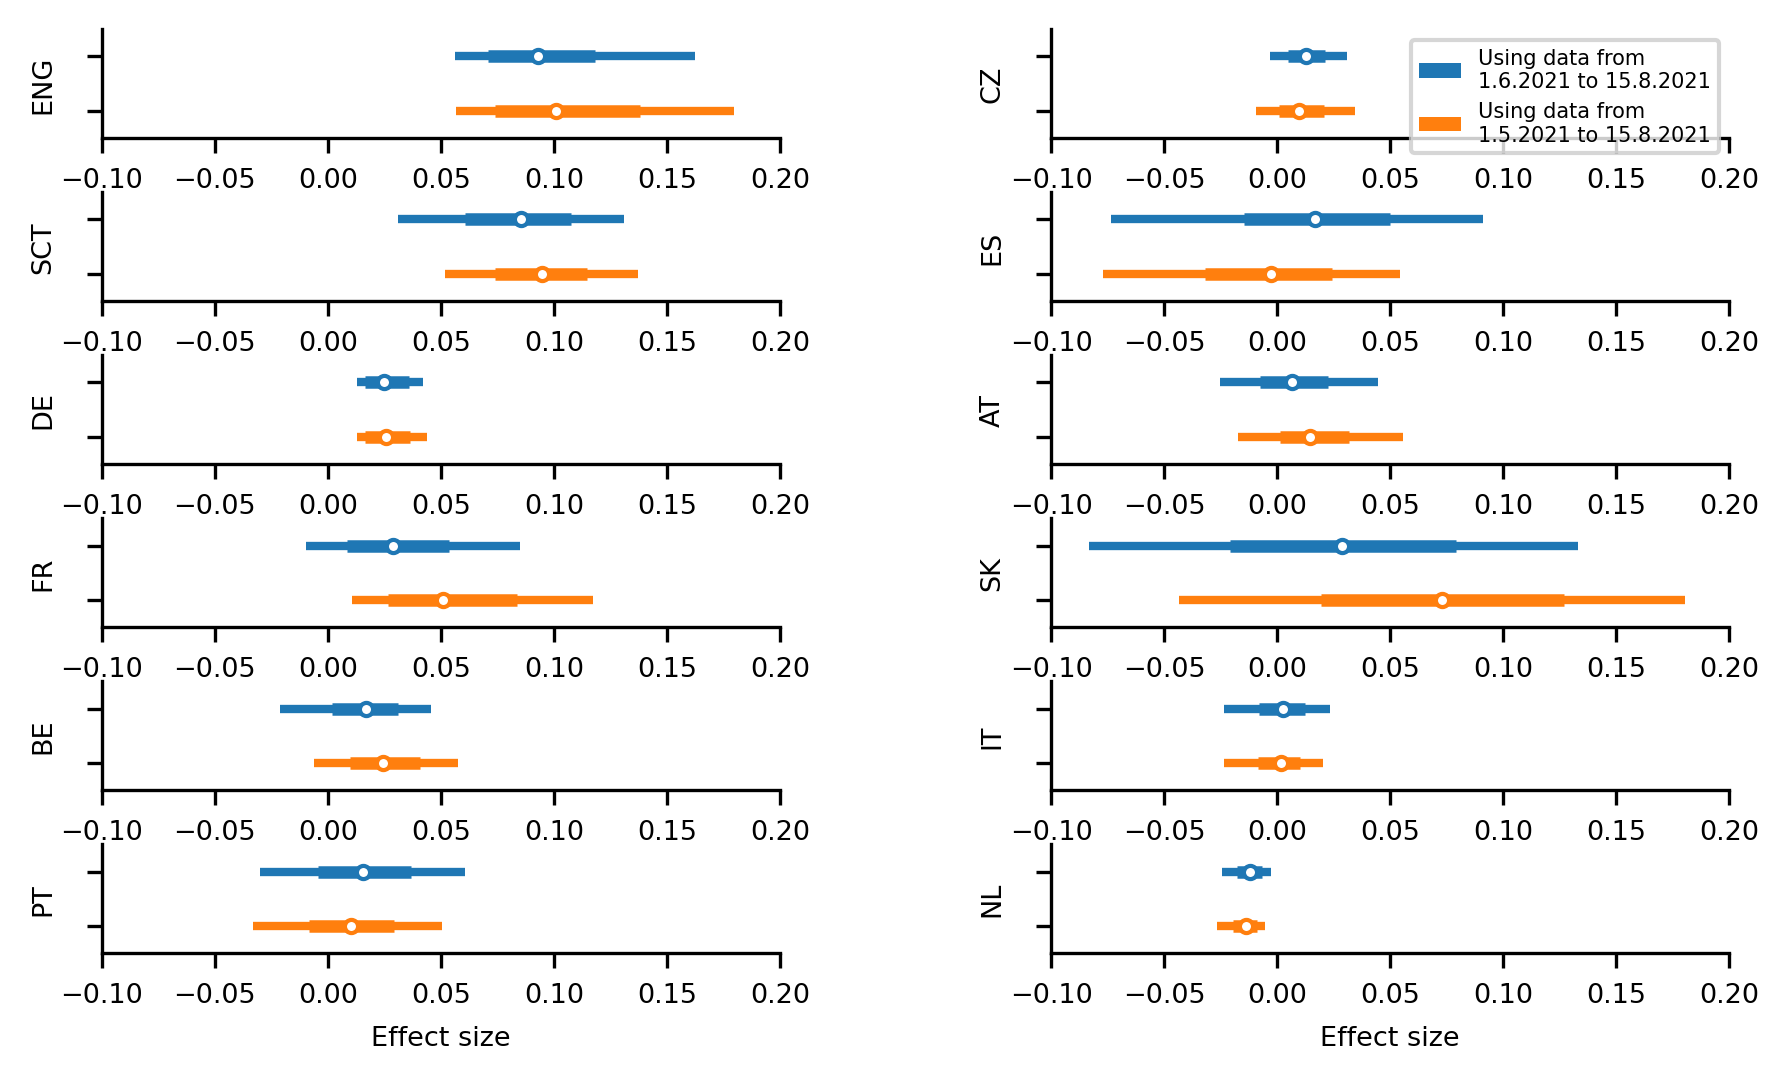

In [6]:
from covid19_soccer.plot.other import calc_fraction_primary
import datetime
fig, axes = plt.subplots(int(len(countries)/2),2, figsize=(7,len(countries)/3),gridspec_kw={"hspace":0.5,"wspace":0.4})

for c, country in enumerate(countries):
    r = 0
    if c >= 6:
        r = 1
    for l, length in enumerate(["long","normal"]):
        model = models[length][c]
        trace = traces[length][c]
        dl = dls[length][c]
        
        color = "tab:blue" if length == "normal" else "tab:orange"
        
        ax = axes[c%6,r]
        begin = datetime.datetime(2021, 6, 11)
        end = datetime.datetime(2021, 7, 31)
        
        primary_frac = calc_fraction_primary(trace, model, dl)
        plot_bar(primary_frac,color,ax,y=l)
        

for ax, dl in zip(axes.flatten(),dls["long"]):
    ax.set_xlim(-0.1,0.2)
    ax.set_ylim(-0.5,1.5)
    ax.set_yticklabels([])
    ax.set_ylabel(dl.countries_iso2[0].replace("GB-",""))
    if dl.countries[0] == "Netherlands":
        ax.set_xlim(-0.1,0.2)
for ax in axes[-1]:
    ax.set_xlabel("Effect size")
        
legend(axes[0,1],loc=1)

plt.show()
fig.savefig(f"../../figures/SI/effect_compare_long_short.pdf", **save_kwargs)
fig.savefig(f"../../figures/SI/effect_compare_long_short.png", **save_kwargs)
plt.close(fig=fig)

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Oct 14 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

matplotlib: 3.5.1
numpy     : 1.20.3
sys       : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]

Watermark: 2.3.1

